In [1]:
#Slef-made Function
from Dataload import dataload
from module import transformer,video_model
from constant import EMOTIPATH,EMOTIFACEPATH,EMOTIAUDIOPATH
from train import methods


#Torch Library

import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import  utils

#Sub tools
import pandas as pd

import os
import matplotlib.pylab as plt

#Util Library
import time
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid  

Train_label=os.path.join(EMOTIPATH,"Train_labels.txt")
Train_video_pt=os.path.join(EMOTIPATH,"pt","Train")
Train_face_pt=os.path.join(EMOTIFACEPATH,"pt_stacked","Train")
Audio_Train=os.path.join(EMOTIAUDIOPATH,"Train_audio.csv")

Val_labels=os.path.join(EMOTIPATH,"Val_labels.txt")
Val_video_pt=os.path.join(EMOTIPATH,"pt","Valid")
Val_face_pt=os.path.join(EMOTIFACEPATH,"pt_stacked","Valid")
Audio_Valid=os.path.join(EMOTIAUDIOPATH,"Val_audio.csv")


train_table = pd.read_csv(Train_label,delimiter=' ')
val_table = pd.read_csv(Val_labels,delimiter=' ')
print(train_table['Label'].value_counts())
print(val_table['Label'].value_counts())



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)



frame_num=10

train_data_pt=dataload.Video_Frame_Data(Train_label,base_path_v=Train_video_pt,face_path=Train_face_pt,frame_num=frame_num,direct=True,audio_csv=Audio_Train)
valid_data_pt=dataload.Video_Frame_Data(Val_labels,base_path_v=Val_video_pt,face_path=Val_face_pt,frame_num=frame_num,direct=True,audio_csv=Audio_Valid)





def load_pretrained_model(pre_train):
    
    face_model=torch.load("pre_trained_model/" +"pre_trained_resnet18_face.h")
    audio_model=video_model.AudioRecognition(softmax=pre_train)
    audio_model.load_state_dict(torch.load("pre_trained_model/pre_embedded_audio.pth"),strict=False)
    image_model=video_model.Video_modeller(frame_num,face_model=face_model,pre_train=pre_train)
    return(image_model,audio_model)



def show_img(dataset,index,frame):
    x=dataset[index][0][frame].cpu().numpy()
    plt.figure(1,(15,15))
    plt.axis('off')
    image = (x*0.5+0.5).transpose((1, 2, 0)).squeeze()
    plt.imshow(image)
    
    fig = plt.figure(2,(15,15))
   # plt.axis('off')
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(1,5),
                     axes_pad=0.1,
                     )
    for i in range(5):
        face=dataset[index][1][frame].cpu().numpy()
        image = (face[i,:]*0.5+0.5).transpose((1, 2, 0)).squeeze()
        grid[i].imshow(image,cmap='gray',interpolation='none')
img_model,audio_model=load_pretrained_model(True)



3    932
2    923
1    806
Name: Label, dtype: int64
1    299
2    281
3    186
Name: Label, dtype: int64


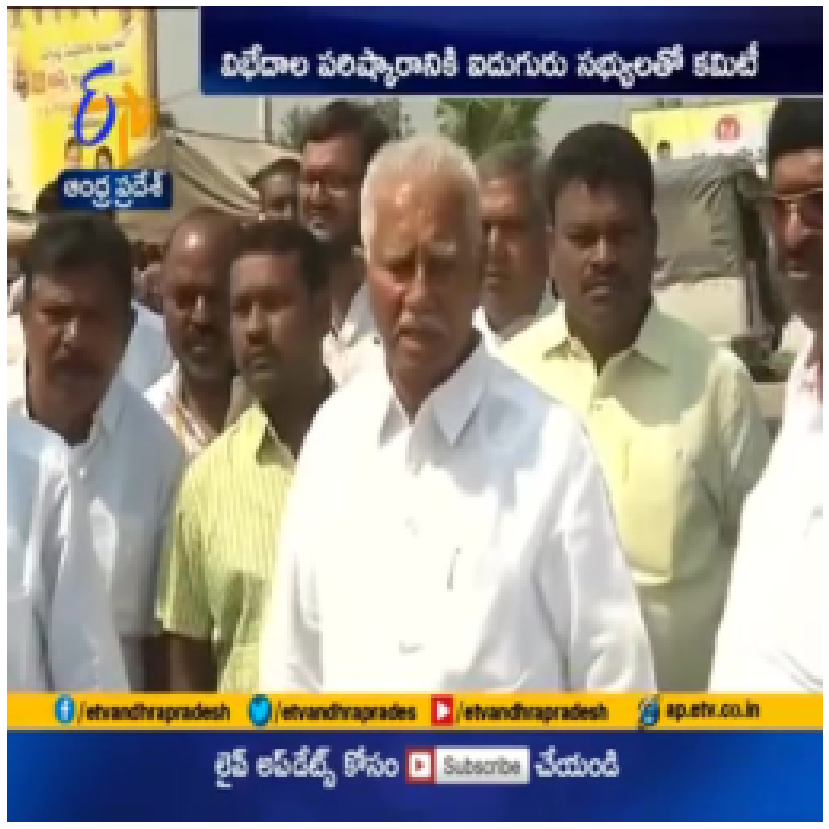

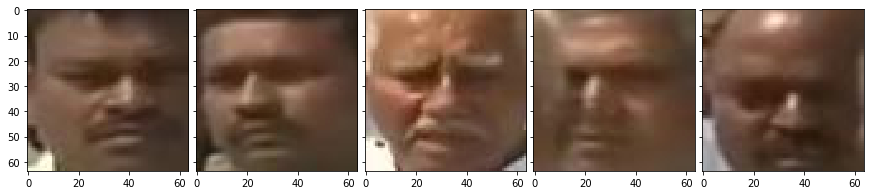

In [2]:
show_img(train_data_pt,1,1)

In [3]:


weights=[932/932,932/923,932/806]
class_weights = torch.FloatTensor(weights).to(device)

train_dataloader = DataLoader(train_data_pt, batch_size=32
                       , num_workers=0,shuffle=True)
valid_dataloader = DataLoader(valid_data_pt, batch_size=32
                   , num_workers=0)

model=img_model.to(device)

num_epochs=50
criterion = nn.CrossEntropyLoss(weight=class_weights)  

for name, child in model.named_children():
    if not name in ['face_model','frame_model' ]:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
               param.requires_grad = False

frame_model is frozen
face_model is frozen
en1 is unfrozen
en2 is unfrozen
fc1 is unfrozen
fc2 is unfrozen
fc3 is unfrozen
dropout is unfrozen


In [ ]:

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005, betas=(0.5, 0.999))


model_name="img_global"

print(model_name)

methods.image_train("saved_model_img",num_epochs,model_name,model,train_dataloader,valid_dataloader,optimizer,criterion,device)


img_global
Epoch:  1 

Validation 

Validation Loss:  1.1171834593017895
Validation Accuracy:  0.24934725848563968
Confusion Matrix: 
 [[  0  12 287]
 [  0   6 275]
 [  0   1 185]]
